# VANGUARD AB TEST


## METADATA HELP

This comprehensive set of fields will guide your analysis, helping you unravel the intricacies of client behavior and preferences.

- **client_id**: Every client’s unique ID.
- **variation**: Indicates if a client was part of the experiment.
- **visitor_id**: A unique ID for each client-device combination.
- **visit_id**: A unique ID for each web visit/session.
- **process_step**: Marks each step in the digital process.
- **date_time**: Timestamp of each web activity.
- **clnt_tenure_yr**: Represents how long the client has been with Vanguard, measured in years.
- **clnt_tenure_mnth**: Further breaks down the client’s tenure with Vanguard in months.
- **clnt_age**: Indicates the age of the client.
- **gendr**: Specifies the client’s gender.
- **num_accts**: Denotes the number of accounts the client holds with Vanguard.
- **bal**: Gives the total balance spread across all accounts for a particular client.
- **calls_6_mnth**: Records the number of times the client reached out over a call in the past six months.
- **logons_6_mnth**: Reflects the frequency with which the client logged onto Vanguard’s platform over the last six months.


In [2]:
%load_ext autoreload
%autoreload 2 

In [3]:
from cleaning import *
from mining import *
from db_handling import *
from analysis import *
import pandas as pd
from dotenv import load_dotenv
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [4]:
# Load environment variables
load_dotenv()

True

### Load Configuration

In [5]:
# Load config.yaml
config = parse_config()

{'database_name': 'vanguard_ab', 'refresh_db': False, 'tables': {'clients': {'sources': [{'path': 'data/df_final_demo.txt', 'url': 'https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_demo.txt'}], 'separator': ',', 'dropna': True, 'columns': {'client_id': {'original_name': 'client_id', 'data_type': 'INTEGER', 'primary_key': True, 'pandas_dtype': 'int64'}, 'client_since_month': {'original_name': 'clnt_tenure_mnth', 'data_type': 'FLOAT', 'pandas_dtype': 'int64'}, 'client_age': {'original_name': 'clnt_age', 'data_type': 'FLOAT', 'pandas_dtype': 'int64'}, 'gender': {'original_name': 'gendr', 'data_type': 'CHAR(1)', 'pandas_dtype': 'category', 'valid_categories': ['U', 'M', 'F'], 'fallback_category': 'U'}, 'number_of_accounts': {'original_name': 'num_accts', 'data_type': 'FLOAT', 'pandas_dtype': 'int64'}, 'balance': {'original_name': 'bal', 'data_type': 'FLOAT', 'pandas_dtype': 'float64'}, 'calls_6_months': 

## Data Mining

In [6]:
# Creates a dictionary of all imported dataframes
dataframes = { name:import_data_from_config(config, name) for name in config['tables']}

## Data Cleaning

In [7]:
#TODO: don't impose categories?

In [8]:
# Rename columns
dataframes = rename_columns(dataframes, config)

In [9]:
# Select columns
dataframes = select_columns(dataframes, config)

In [10]:
display_dataFrames(dataframes,'head','shape','describe')

clients:
clients - Head:


,client_id,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,145.0,33.0,F,2.0,103671.75,0.0,3.0


clients - Shape:


(70609, 8)

clients - Describe:


,client_id,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
count,7.060900e+04,70595.000000,70594.000000,70595,70595.000000,7.059500e+04,70595.000000,70595.000000
unique,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,U,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,24122,NaN,NaN,NaN,NaN
mean,5.004992e+06,150.659367,46.442240,NaN,2.255528,1.474452e+05,3.382478,5.566740
std,2.877278e+06,82.089854,15.591273,NaN,0.534997,3.015087e+05,2.236580,2.353286
min,1.690000e+02,33.000000,13.500000,NaN,1.000000,1.378942e+04,0.000000,1.000000
25%,2.519329e+06,82.000000,32.500000,NaN,2.000000,3.734683e+04,1.000000,4.000000
50%,5.016978e+06,136.000000,47.000000,NaN,2.000000,6.333290e+04,3.000000,5.000000
75%,7.483085e+06,192.000000,59.000000,NaN,2.000000,1.375449e+05,6.000000,7.000000


experiment:
experiment - Head:


,client_id,variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


experiment - Shape:


(70609, 2)

experiment - Describe:


,client_id,variation
count,7.060900e+04,50500
unique,NaN,2
top,NaN,Test
freq,NaN,26968
mean,5.004992e+06,NaN
std,2.877278e+06,NaN
min,1.690000e+02,NaN
25%,2.519329e+06,NaN
50%,5.016978e+06,NaN
75%,7.483085e+06,NaN


visits:
visits - Head:


,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


visits - Shape:


(755405, 5)

visits - Describe:


,client_id,visitor_id,visit_id,process_step,date_time
count,7.554050e+05,755405,755405,755405,755405
unique,NaN,130236,158095,5,629363
top,NaN,722943003_3441581446,875138661_34710212496_881092,start,2017-05-02 10:07:41
freq,NaN,104,104,243945,24
mean,5.013632e+06,NaN,NaN,NaN,NaN
std,2.879152e+06,NaN,NaN,NaN,NaN
min,1.690000e+02,NaN,NaN,NaN,NaN
25%,2.519882e+06,NaN,NaN,NaN,NaN
50%,5.033441e+06,NaN,NaN,NaN,NaN
75%,7.496063e+06,NaN,NaN,NaN,NaN


### Separation

In [11]:
client_df = dataframes['clients']
experiment_df = dataframes['experiment']
visits_df = dataframes['visits']
display (client_df, experiment_df, visits_df)

,client_id,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,145.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...
70604,7993686,56.0,38.5,U,3.0,1411062.68,5.0,5.0
70605,8981690,148.0,31.0,M,2.0,101867.07,6.0,6.0
70606,333913,198.0,61.5,F,2.0,40745.00,3.0,3.0
70607,1573142,255.0,68.0,M,3.0,475114.69,4.0,4.0


,client_id,variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
70604,2443347,NaN
70605,8788427,NaN
70606,266828,NaN
70607,1266421,NaN


,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
755400,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
755401,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
755402,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
755403,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


In [12]:
display(visits_df.describe(include='all'))

,client_id,visitor_id,visit_id,process_step,date_time
count,7.554050e+05,755405,755405,755405,755405
unique,NaN,130236,158095,5,629363
top,NaN,722943003_3441581446,875138661_34710212496_881092,start,2017-05-02 10:07:41
freq,NaN,104,104,243945,24
mean,5.013632e+06,NaN,NaN,NaN,NaN
std,2.879152e+06,NaN,NaN,NaN,NaN
min,1.690000e+02,NaN,NaN,NaN,NaN
25%,2.519882e+06,NaN,NaN,NaN,NaN
50%,5.033441e+06,NaN,NaN,NaN,NaN
75%,7.496063e+06,NaN,NaN,NaN,NaN


In [13]:
# drop the nulls from clients, but keep the list of the drops

nulls_client_id = client_df[client_df.isna().any(axis=1)]['client_id']
nulls_client_id

4164     7402828
8316      355337
8677     8412164
9583     4666211
13444    2222915
18066    4876926
25961    5277910
28432    7616759
35323    8191345
43518    1227228
46076    8611797
47189    5144725
49846    1037867
63701    1618749
66219    6021001
Name: client_id, dtype: int64

In [14]:
client_df = client_df.dropna(axis=0)
client_df

,client_id,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,145.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...
70604,7993686,56.0,38.5,U,3.0,1411062.68,5.0,5.0
70605,8981690,148.0,31.0,M,2.0,101867.07,6.0,6.0
70606,333913,198.0,61.5,F,2.0,40745.00,3.0,3.0
70607,1573142,255.0,68.0,M,3.0,475114.69,4.0,4.0


In [15]:
display(experiment_df['variation'].value_counts(dropna = False))
# keep NaN for general analysis of clients, but drop them from everywhere for test analysis

variation
Test       26968
Control    23532
NaN        20109
Name: count, dtype: int64

In [16]:
# client_df, experiment_df, visit_df -> for general analysis
# new_client_df, new_experiment_df, new_visit_dfn -> for test/control analysis   experiment_df_null = 
nulls_in_experiment = experiment_df[experiment_df.isna().any(axis=1)]['client_id']
nulls_in_experiment

50500    5459747
50501    8031000
50502    1847030
50503    9713157
50504    7775828
          ...   
70604    2443347
70605    8788427
70606     266828
70607    1266421
70608    9895983
Name: client_id, Length: 20109, dtype: int64

In [17]:
# new df removing client ID that are null in experiment

display(experiment_df.count())
new_experiment_df = experiment_df[~experiment_df['client_id'].isin(nulls_in_experiment)]
display(new_experiment_df.count())

new_experiment_df = new_experiment_df[~new_experiment_df['client_id'].isin(nulls_client_id)]
display(new_experiment_df.count())
display(new_experiment_df.isna().sum())



client_id    70609
variation    50500
dtype: int64

client_id    50500
variation    50500
dtype: int64

client_id    50487
variation    50487
dtype: int64

client_id    0
variation    0
dtype: int64

In [18]:
display(visits_df)
new_visits_df = visits_df[~visits_df['client_id'].isin(nulls_in_experiment)]
display(new_visits_df)
display(new_visits_df.isna().sum())

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
755400,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
755401,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
755402,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
755403,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
755400,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
755401,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
755402,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
755403,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64

In [19]:
display(client_df)
new_client_df = client_df[~client_df['client_id'].isin(nulls_in_experiment)]
display(new_client_df)

,client_id,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,145.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...
70604,7993686,56.0,38.5,U,3.0,1411062.68,5.0,5.0
70605,8981690,148.0,31.0,M,2.0,101867.07,6.0,6.0
70606,333913,198.0,61.5,F,2.0,40745.00,3.0,3.0
70607,1573142,255.0,68.0,M,3.0,475114.69,4.0,4.0


,client_id,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,145.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...
50495,1780858,262.0,68.5,M,3.0,372100.59,6.0,9.0
50496,6967120,260.0,68.5,M,3.0,4279873.38,6.0,9.0
50497,5826160,249.0,56.5,F,2.0,44837.16,2.0,5.0
50498,8739285,229.0,69.5,F,2.0,44994.24,1.0,4.0


### End separation

In [20]:
dataframes['clients'] = new_client_df.copy()
dataframes['experiment'] = new_experiment_df.copy()
dataframes['visits'] = new_visits_df.copy()

In [21]:
# Data Categorizing
dataframes = clean_categorical_data(dataframes, config)

In [22]:
#Convert types
dataframes = convert_types(dataframes, config)

In [23]:
display_dataFrames(dataframes, 'head', 'shape', 'cat_count')

clients:
clients - Head:


,client_id,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73,60,U,2,45105.30,6,9
1,2304905,94,58,U,2,110860.30,6,9
2,1439522,64,32,U,2,52467.79,6,9
3,1562045,198,49,M,2,67454.65,3,6
4,5126305,145,33,F,2,103671.75,0,3


clients - Shape:


(50487, 8)

clients - Cat_count:


,gender
gender,
U,17282
M,16947
F,16258


experiment:
experiment - Head:


,client_id,variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


experiment - Shape:


(50487, 2)

experiment - Cat_count:


,variation
variation,
Test,26961
Control,23526


visits:
visits - Head:


,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


visits - Shape:


(626883, 5)

visits - Cat_count:


,process_step
process_step,
start,202439
step_1,135733
step_2,110366
step_3,92714
confirm,85631


In [24]:
client_df = dataframes['clients']
experiment_df = dataframes['experiment']
visits_df = dataframes['visits']

In [25]:
display(client_df.describe(include='all'))
display(client_df.dtypes)

,client_id,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
count,5.048700e+04,50487.000000,50487.000000,50487,50487.000000,5.048700e+04,50487.000000,50487.000000
unique,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,U,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,17282,NaN,NaN,NaN,NaN
mean,5.006180e+06,150.416365,47.058451,NaN,2.254580,1.495168e+05,3.093272,6.131856
std,2.877445e+06,81.945403,15.528092,NaN,0.533675,3.020390e+05,2.188009,2.175441
min,5.550000e+02,33.000000,17.000000,NaN,1.000000,2.378944e+04,0.000000,3.000000
25%,2.515688e+06,82.000000,33.000000,NaN,2.000000,3.987718e+04,1.000000,4.000000
50%,5.025043e+06,136.000000,48.000000,NaN,2.000000,6.573433e+04,3.000000,6.000000
75%,7.477922e+06,192.000000,59.000000,NaN,2.000000,1.399583e+05,5.000000,8.000000


client_id                int64
client_since_month       int64
client_age               int64
gender                category
number_of_accounts       int64
balance                float64
calls_6_months           int64
logons_6_month           int64
dtype: object

### SQL EXPORT

In [26]:
if config['refresh_db']:

    db_password = os.getenv('SQL_PASSWORD')

    # Create database if it doesn't exist
    engine = create_db(db_password, config)

    # Export tables to database if refresh is set to true
    export_dataframes_to_sql(engine, dataframes)

    # Import data from database
    dataframes = import_all_tables_from_sql(engine)

### Local Caching

In [27]:
""" # Save files locally in an untracked folder
export_dataframes_to_csv(dataframes) """

' # Save files locally in an untracked folder\nexport_dataframes_to_csv(dataframes) '

In [28]:
#TODO CAREFUL DATA WONT BE PROPERLY CATEGORIZED / TYPED run after : convert_types(dataframes, config)
""" clients_df = pd.read_csv('data/cleaned/clients.csv')
experiment_df = pd.read_csv('data/cleaned/experiment.csv')
visits_df = pd.read_csv('data/cleaned/visits.csv') """

" clients_df = pd.read_csv('data/cleaned/clients.csv')\nexperiment_df = pd.read_csv('data/cleaned/experiment.csv')\nvisits_df = pd.read_csv('data/cleaned/visits.csv') "

## CLEAN FRAMES

In [29]:
display('clients :',client_df, 'experiment :',experiment_df, 'visits :',visits_df)
display('clients :',client_df.describe(include='all'), 'experiment :',experiment_df.describe(include='all'), 'visits :',visits_df.describe(include='all'))
display('clients :',client_df.dtypes, 'experiment :',experiment_df.dtypes, 'visits :',visits_df.dtypes)

experiment_df['variation'].value_counts()


'clients :'

,client_id,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73,60,U,2,45105.30,6,9
1,2304905,94,58,U,2,110860.30,6,9
2,1439522,64,32,U,2,52467.79,6,9
3,1562045,198,49,M,2,67454.65,3,6
4,5126305,145,33,F,2,103671.75,0,3
...,...,...,...,...,...,...,...,...
50495,1780858,262,68,M,3,372100.59,6,9
50496,6967120,260,68,M,3,4279873.38,6,9
50497,5826160,249,56,F,2,44837.16,2,5
50498,8739285,229,69,F,2,44994.24,1,4


'experiment :'

,client_id,variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
50495,393005,Control
50496,2908510,Control
50497,7230446,Test
50498,5230357,Test


'visits :'

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
755400,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
755401,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
755402,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
755403,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


'clients :'

,client_id,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
count,5.048700e+04,50487.000000,50487.000000,50487,50487.000000,5.048700e+04,50487.000000,50487.000000
unique,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,U,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,17282,NaN,NaN,NaN,NaN
mean,5.006180e+06,150.416365,47.058451,NaN,2.254580,1.495168e+05,3.093272,6.131856
std,2.877445e+06,81.945403,15.528092,NaN,0.533675,3.020390e+05,2.188009,2.175441
min,5.550000e+02,33.000000,17.000000,NaN,1.000000,2.378944e+04,0.000000,3.000000
25%,2.515688e+06,82.000000,33.000000,NaN,2.000000,3.987718e+04,1.000000,4.000000
50%,5.025043e+06,136.000000,48.000000,NaN,2.000000,6.573433e+04,3.000000,6.000000
75%,7.477922e+06,192.000000,59.000000,NaN,2.000000,1.399583e+05,5.000000,8.000000


'experiment :'

,client_id,variation
count,5.048700e+04,50487
unique,NaN,2
top,NaN,Test
freq,NaN,26961
mean,5.006180e+06,NaN
std,2.877445e+06,NaN
min,5.550000e+02,NaN
25%,2.515688e+06,NaN
50%,5.025043e+06,NaN
75%,7.477922e+06,NaN


'visits :'

,client_id,visitor_id,visit_id,process_step,date_time
count,6.268830e+05,626883,626883,626883,626883
unique,NaN,108216,130607,5,NaN
top,NaN,857376424_12378092455,518285126_8572733997_709761,start,NaN
freq,NaN,90,88,202439,NaN
mean,5.019375e+06,NaN,NaN,NaN,2017-05-11 13:31:09.304526080
min,3.360000e+02,NaN,NaN,NaN,2017-03-15 00:19:28
25%,2.520436e+06,NaN,NaN,NaN,2017-04-12 11:21:16
50%,5.048509e+06,NaN,NaN,NaN,2017-05-24 12:42:27
75%,7.500857e+06,NaN,NaN,NaN,2017-06-04 22:13:12.500000
max,9.999875e+06,NaN,NaN,NaN,2017-06-20 23:59:57


'clients :'

client_id                int64
client_since_month       int64
client_age               int64
gender                category
number_of_accounts       int64
balance                float64
calls_6_months           int64
logons_6_month           int64
dtype: object

'experiment :'

client_id       int64
variation    category
dtype: object

'visits :'

client_id                int64
visitor_id              object
visit_id                object
process_step          category
date_time       datetime64[ns]
dtype: object

variation
Test       26961
Control    23526
Name: count, dtype: int64

## Data Exploration

### Merge frames

In [30]:
# Added variation column to visits for easier analysis
visits_variations = visits_df.merge(experiment_df, on='client_id', how='inner')
display(visits_variations)
display(visits_variations.dtypes)

,client_id,visitor_id,visit_id,process_step,date_time,variation
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test
...,...,...,...,...,...,...
321190,1574008,117364417_77840596075,528720790_71583064618_169151,start,2017-05-06 23:43:27,Test
321191,2908510,814969699_90652851448,562606085_36368381773_92090,start,2017-05-10 22:57:17,Control
321192,2908510,814969699_90652851448,562606085_36368381773_92090,step_2,2017-05-10 22:56:31,Control
321193,2908510,814969699_90652851448,562606085_36368381773_92090,step_1,2017-05-10 22:56:23,Control


client_id                int64
visitor_id              object
visit_id                object
process_step          category
date_time       datetime64[ns]
variation             category
dtype: object

In [31]:
# Merge clients and visits for demographic analysis
visits_variations = visits_variations.merge(client_df, on='client_id', how='inner')
display(visits_variations)
display(visits_variations.dtypes)


,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,64,79,U,2,189023.86,1,4
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,64,79,U,2,189023.86,1,4
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,64,79,U,2,189023.86,1,4
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,64,79,U,2,189023.86,1,4
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,64,79,U,2,189023.86,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
321190,1574008,117364417_77840596075,528720790_71583064618_169151,start,2017-05-06 23:43:27,Test,121,55,U,2,153238.83,3,6
321191,2908510,814969699_90652851448,562606085_36368381773_92090,start,2017-05-10 22:57:17,Control,252,34,M,3,141808.05,6,9
321192,2908510,814969699_90652851448,562606085_36368381773_92090,step_2,2017-05-10 22:56:31,Control,252,34,M,3,141808.05,6,9
321193,2908510,814969699_90652851448,562606085_36368381773_92090,step_1,2017-05-10 22:56:23,Control,252,34,M,3,141808.05,6,9


client_id                      int64
visitor_id                    object
visit_id                      object
process_step                category
date_time             datetime64[ns]
variation                   category
client_since_month             int64
client_age                     int64
gender                      category
number_of_accounts             int64
balance                      float64
calls_6_months                 int64
logons_6_month                 int64
dtype: object

### Sort visits by time

In [32]:
# sort by visit_id and date_time to see the process steps in order
visits_variations = visits_variations.sort_values(by=['visit_id', 'date_time'], ascending=[True, True])
display(visits_variations)


,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
106827,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,Test,56,59,U,2,63130.44,6,9
106826,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,Test,56,59,U,2,63130.44,6,9
236490,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,23,M,2,26436.73,6,9
236489,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,23,M,2,26436.73,6,9
236488,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,23,M,2,26436.73,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95624,6627522,730634087_44272418812,999988789_76411676596_272843,start,2017-04-21 23:49:11,Test,227,58,F,2,1056775.54,6,9
95623,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:49:22,Test,227,58,F,2,1056775.54,6,9
95622,6627522,730634087_44272418812,999988789_76411676596_272843,step_2,2017-04-21 23:50:16,Test,227,58,F,2,1056775.54,6,9
95621,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:51:00,Test,227,58,F,2,1056775.54,6,9


### Remove repeat visits


In [33]:
first_visit = visits_variations.drop_duplicates(subset='client_id', keep='first')
selected_visits = first_visit['visit_id']
display(selected_visits)

visits_variations = visits_variations[visits_variations['visit_id'].isin(selected_visits)]
display(visits_variations)


106827    100012776_37918976071_457913
236490     100019538_17884295066_43909
243695    100022086_87870757897_149620
235338    100030127_47967100085_936361
27085     100037962_47432393712_705583
                      ...             
181050    999954858_74676709104_879685
73134      999958344_67534252886_39917
8441      999971096_28827267783_236076
209404    999976049_95772503197_182554
90971     999985675_64610694964_443659
Name: visit_id, Length: 50487, dtype: object

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
106827,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,Test,56,59,U,2,63130.44,6,9
106826,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,Test,56,59,U,2,63130.44,6,9
236490,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,23,M,2,26436.73,6,9
236489,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,23,M,2,26436.73,6,9
236488,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,23,M,2,26436.73,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90971,4064969,110735946_42614968419,999985675_64610694964_443659,start,2017-04-20 09:45:18,Control,75,64,U,2,74783.76,5,8
90970,4064969,110735946_42614968419,999985675_64610694964_443659,step_1,2017-04-20 09:46:26,Control,75,64,U,2,74783.76,5,8
90969,4064969,110735946_42614968419,999985675_64610694964_443659,step_2,2017-04-20 09:47:04,Control,75,64,U,2,74783.76,5,8
90968,4064969,110735946_42614968419,999985675_64610694964_443659,step_3,2017-04-20 09:48:45,Control,75,64,U,2,74783.76,5,8


## OUTLIERS

### Time taken

In [34]:
visits_variations['time_taken'] = visits_variations.groupby('visit_id')['date_time'].diff().dt.total_seconds()
visits_variations['time_taken'] = visits_variations['time_taken'].fillna(0)

display(visits_variations)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken
106827,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,Test,56,59,U,2,63130.44,6,9,0.0
106826,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,Test,56,59,U,2,63130.44,6,9,52.0
236490,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,23,M,2,26436.73,6,9,0.0
236489,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,23,M,2,26436.73,6,9,16.0
236488,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,23,M,2,26436.73,6,9,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90971,4064969,110735946_42614968419,999985675_64610694964_443659,start,2017-04-20 09:45:18,Control,75,64,U,2,74783.76,5,8,0.0
90970,4064969,110735946_42614968419,999985675_64610694964_443659,step_1,2017-04-20 09:46:26,Control,75,64,U,2,74783.76,5,8,68.0
90969,4064969,110735946_42614968419,999985675_64610694964_443659,step_2,2017-04-20 09:47:04,Control,75,64,U,2,74783.76,5,8,38.0
90968,4064969,110735946_42614968419,999985675_64610694964_443659,step_3,2017-04-20 09:48:45,Control,75,64,U,2,74783.76,5,8,101.0


In [35]:
# add a column to show the total time taken for each visit_id
visits_variations['total_time_taken'] = visits_variations.groupby('visit_id')['time_taken'].transform('sum')
display(visits_variations)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
106827,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,Test,56,59,U,2,63130.44,6,9,0.0,52.0
106826,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,Test,56,59,U,2,63130.44,6,9,52.0,52.0
236490,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,23,M,2,26436.73,6,9,0.0,242.0
236489,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,23,M,2,26436.73,6,9,16.0,242.0
236488,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,23,M,2,26436.73,6,9,9.0,242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90971,4064969,110735946_42614968419,999985675_64610694964_443659,start,2017-04-20 09:45:18,Control,75,64,U,2,74783.76,5,8,0.0,1050.0
90970,4064969,110735946_42614968419,999985675_64610694964_443659,step_1,2017-04-20 09:46:26,Control,75,64,U,2,74783.76,5,8,68.0,1050.0
90969,4064969,110735946_42614968419,999985675_64610694964_443659,step_2,2017-04-20 09:47:04,Control,75,64,U,2,74783.76,5,8,38.0,1050.0
90968,4064969,110735946_42614968419,999985675_64610694964_443659,step_3,2017-04-20 09:48:45,Control,75,64,U,2,74783.76,5,8,101.0,1050.0


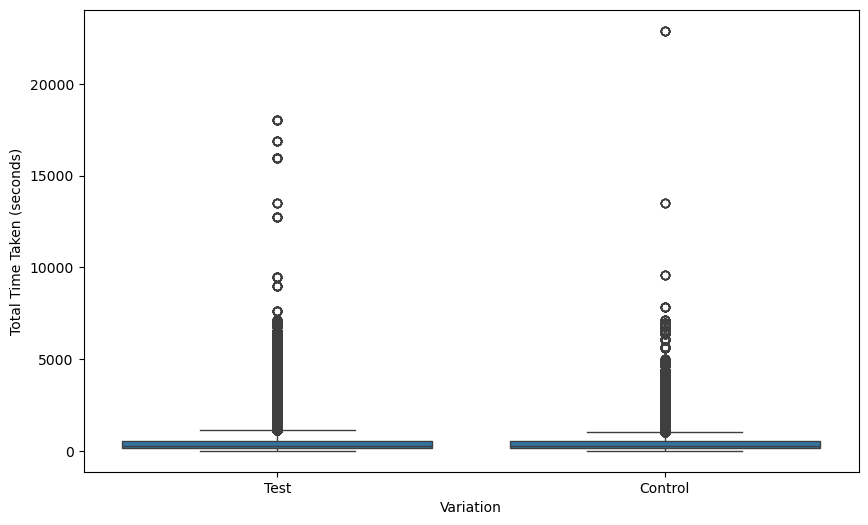

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='variation', y='total_time_taken', data=visits_variations)
plt.xlabel('Variation')
plt.ylabel('Total Time Taken (seconds)')
plt.show()

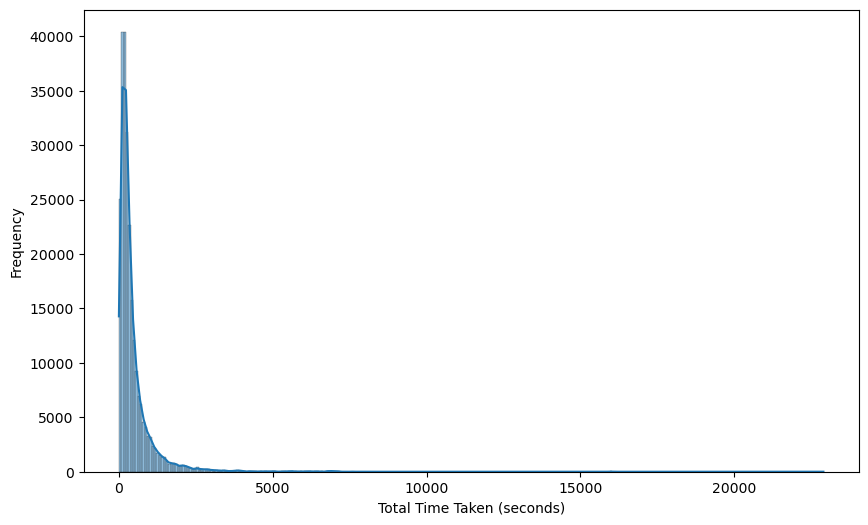

In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(data=visits_variations, x='total_time_taken', kde=True, bins=300)
plt.xlabel('Total Time Taken (seconds)')
plt.ylabel('Frequency')
plt.show()

In [38]:
variations_outliers = tukeys_test_outliers(visits_variations['total_time_taken'], method="show")
display(variations_outliers)
display(variations_outliers.describe())

visits_variations = visits_variations[~visits_variations['total_time_taken'].isin(variations_outliers)]
display(visits_variations)
display(visits_variations.describe(include='all'))
display(visits_variations.dtypes)


16856    1017.0
16855    1017.0
16854    1017.0
16853    1017.0
16852    1017.0
          ...  
90971    1050.0
90970    1050.0
90969    1050.0
90968    1050.0
90967    1050.0
Name: total_time_taken, Length: 29759, dtype: float64

count    29759.000000
mean      1765.022548
std       1342.791715
min        893.000000
25%       1067.000000
50%       1344.000000
75%       1941.000000
max      22895.000000
Name: total_time_taken, dtype: float64

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
106827,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,Test,56,59,U,2,63130.44,6,9,0.0,52.0
106826,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,Test,56,59,U,2,63130.44,6,9,52.0,52.0
236490,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,23,M,2,26436.73,6,9,0.0,242.0
236489,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,23,M,2,26436.73,6,9,16.0,242.0
236488,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,23,M,2,26436.73,6,9,9.0,242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209403,4449968,842902495_57580498240,999976049_95772503197_182554,step_1,2017-04-04 12:52:26,Test,252,53,F,4,124701.46,2,5,136.0,728.0
209402,4449968,842902495_57580498240,999976049_95772503197_182554,step_2,2017-04-04 12:53:01,Test,252,53,F,4,124701.46,2,5,35.0,728.0
209401,4449968,842902495_57580498240,999976049_95772503197_182554,step_3,2017-04-04 12:54:54,Test,252,53,F,4,124701.46,2,5,113.0,728.0
209400,4449968,842902495_57580498240,999976049_95772503197_182554,step_3,2017-04-04 12:59:35,Test,252,53,F,4,124701.46,2,5,281.0,728.0


,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
count,2.175440e+05,217544,217544,217544,217544,217544,217544.000000,217544.000000,217544,217544.000000,2.175440e+05,217544.000000,217544.000000,217544.00000,217544.000000
unique,NaN,46774,46887,5,NaN,2,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,857376424_12378092455,518285126_8572733997_709761,start,NaN,Test,NaN,NaN,U,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,88,88,66604,NaN,119315,NaN,NaN,76530,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.004340e+06,NaN,NaN,NaN,2017-04-19 20:56:08.778348288,NaN,148.399694,46.446875,NaN,2.252597,1.470662e+05,3.086162,6.123336,46.66980,286.083730
min,5.550000e+02,NaN,NaN,NaN,2017-03-15 00:19:28,NaN,33.000000,17.000000,NaN,1.000000,2.378944e+04,0.000000,3.000000,0.00000,0.000000
25%,2.506177e+06,NaN,NaN,NaN,2017-04-03 23:26:57.249999872,NaN,81.000000,33.000000,NaN,2.000000,3.944915e+04,1.000000,4.000000,3.00000,134.000000
50%,5.035620e+06,NaN,NaN,NaN,2017-04-12 12:28:20.500000,NaN,132.000000,47.000000,NaN,2.000000,6.451716e+04,3.000000,6.000000,20.00000,235.000000
75%,7.468016e+06,NaN,NaN,NaN,2017-04-28 17:51:31.500000,NaN,190.000000,59.000000,NaN,2.000000,1.365325e+05,5.000000,8.000000,59.00000,395.000000
max,9.999832e+06,NaN,NaN,NaN,2017-06-20 23:26:00,NaN,669.000000,96.000000,NaN,7.000000,1.632004e+07,6.000000,9.000000,888.00000,892.000000


client_id                      int64
visitor_id                    object
visit_id                      object
process_step                category
date_time             datetime64[ns]
variation                   category
client_since_month             int64
client_age                     int64
gender                      category
number_of_accounts             int64
balance                      float64
calls_6_months                 int64
logons_6_month                 int64
time_taken                   float64
total_time_taken             float64
dtype: object

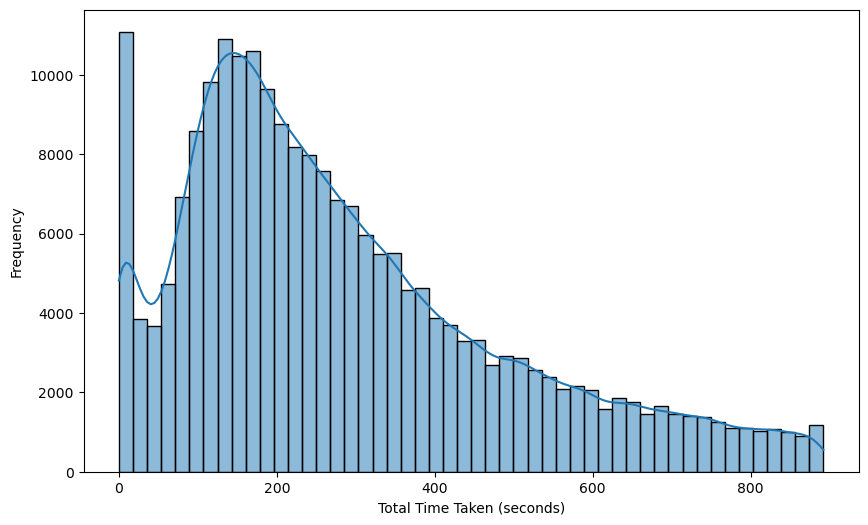

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(data=visits_variations, x='total_time_taken', kde=True, bins=50)
plt.xlabel('Total Time Taken (seconds)')
plt.ylabel('Frequency')
plt.show()

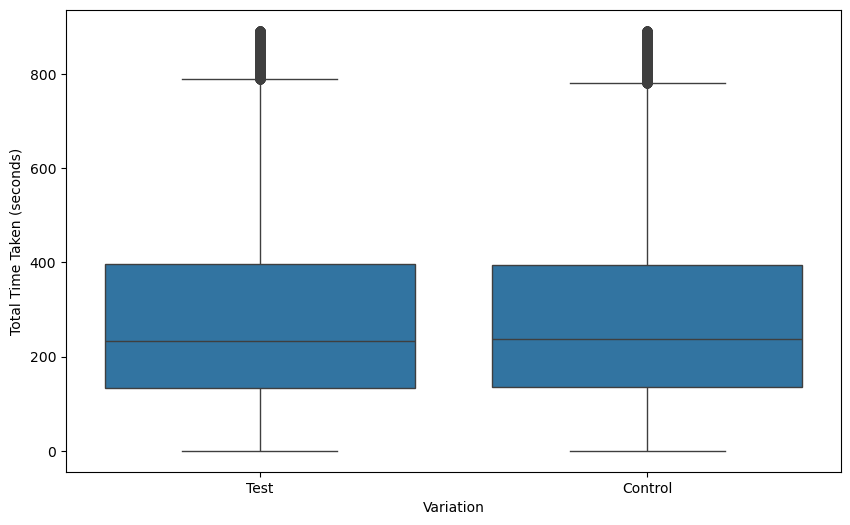

count    217544.000000
mean        286.083730
std         206.307745
min           0.000000
25%         134.000000
50%         235.000000
75%         395.000000
max         892.000000
Name: total_time_taken, dtype: float64

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='variation', y='total_time_taken', data=visits_variations)
plt.xlabel('Variation')
plt.ylabel('Total Time Taken (seconds)')
plt.show()

visits_variations['total_time_taken'].describe()

### Correlation matrix

,client_id,client_since_month,client_age,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
client_id,1.000000,0.006300,-0.002074,-0.003703,-0.001406,-0.006447,-0.006428,-0.000639,-0.001478
client_since_month,0.006300,1.000000,0.312946,0.144554,0.203950,0.045052,0.049741,-0.005201,0.006570
client_age,-0.002074,0.312946,1.000000,-0.025159,0.204071,0.047898,0.056330,0.004368,0.102389
number_of_accounts,-0.003703,0.144554,-0.025159,1.000000,0.263293,0.236778,0.240717,-0.013167,-0.037478
balance,-0.001406,0.203950,0.204071,0.263293,1.000000,0.167318,0.173524,-0.010229,0.008442
calls_6_months,-0.006447,0.045052,0.047898,0.236778,0.167318,1.000000,0.994762,-0.014844,-0.047795
logons_6_month,-0.006428,0.049741,0.056330,0.240717,0.173524,0.994762,1.000000,-0.014405,-0.046255
time_taken,-0.000639,-0.005201,0.004368,-0.013167,-0.010229,-0.014844,-0.014405,1.000000,0.087379
total_time_taken,-0.001478,0.006570,0.102389,-0.037478,0.008442,-0.047795,-0.046255,0.087379,1.000000


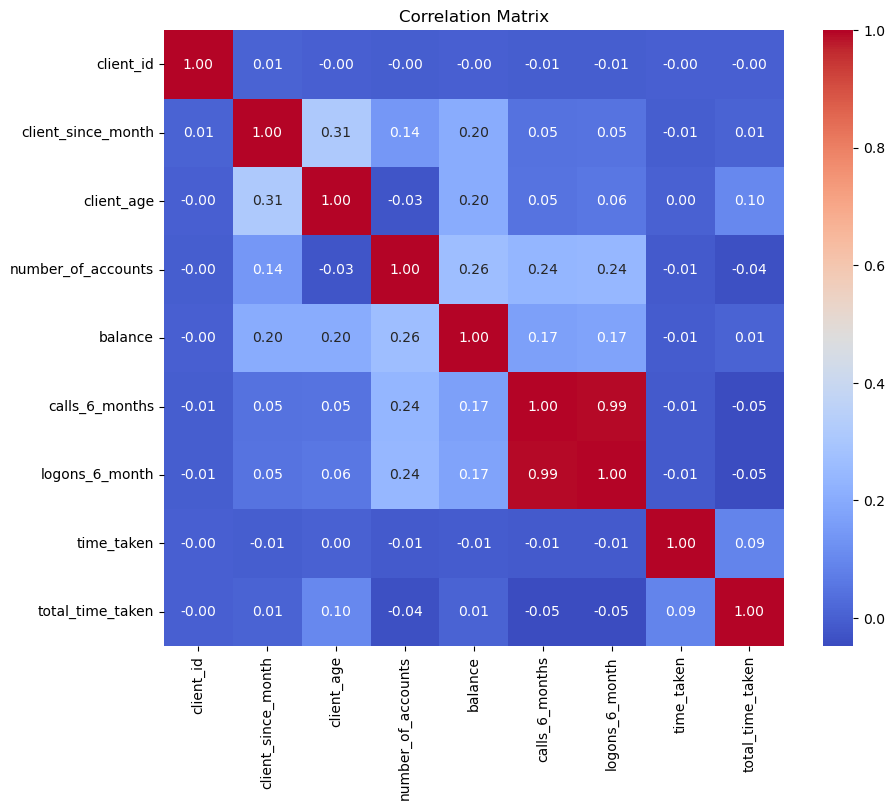

In [41]:
# select all clients
visits_by_client_ids = visits_variations.drop_duplicates(subset='client_id', keep='first')

# Select numerical columns
numerical_data = visits_by_client_ids.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numerical_data.corr()

# Display the correlation matrix
display(correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### Count visits

In [42]:
# Total number of visits per variation to calculate the success rate later
number_of_visits = visits_variations.groupby('variation', observed=False)['visit_id'].nunique()
display(number_of_visits)

variation
Test       24916
Control    22035
Name: visit_id, dtype: int64

### Time taken

In [43]:
# Average total time taken per variation
average_total_time_ = visits_variations.groupby('variation', observed=False)['total_time_taken'].mean()
display(average_total_time_)

variation
Test       286.201760
Control    285.940364
Name: total_time_taken, dtype: float64

In [44]:
display(visits_variations.describe(include='all'))

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
count,2.175440e+05,217544,217544,217544,217544,217544,217544.000000,217544.000000,217544,217544.000000,2.175440e+05,217544.000000,217544.000000,217544.00000,217544.000000
unique,NaN,46774,46887,5,NaN,2,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,857376424_12378092455,518285126_8572733997_709761,start,NaN,Test,NaN,NaN,U,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,88,88,66604,NaN,119315,NaN,NaN,76530,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.004340e+06,NaN,NaN,NaN,2017-04-19 20:56:08.778348288,NaN,148.399694,46.446875,NaN,2.252597,1.470662e+05,3.086162,6.123336,46.66980,286.083730
min,5.550000e+02,NaN,NaN,NaN,2017-03-15 00:19:28,NaN,33.000000,17.000000,NaN,1.000000,2.378944e+04,0.000000,3.000000,0.00000,0.000000
25%,2.506177e+06,NaN,NaN,NaN,2017-04-03 23:26:57.249999872,NaN,81.000000,33.000000,NaN,2.000000,3.944915e+04,1.000000,4.000000,3.00000,134.000000
50%,5.035620e+06,NaN,NaN,NaN,2017-04-12 12:28:20.500000,NaN,132.000000,47.000000,NaN,2.000000,6.451716e+04,3.000000,6.000000,20.00000,235.000000
75%,7.468016e+06,NaN,NaN,NaN,2017-04-28 17:51:31.500000,NaN,190.000000,59.000000,NaN,2.000000,1.365325e+05,5.000000,8.000000,59.00000,395.000000
max,9.999832e+06,NaN,NaN,NaN,2017-06-20 23:26:00,NaN,669.000000,96.000000,NaN,7.000000,1.632004e+07,6.000000,9.000000,888.00000,892.000000


## Happy Path

In [45]:
# function to filter visits with our happy path
def filter_visits_with_happy_path(df):
    def check_sequence(group):
        steps = list(group['process_step'])
        return steps == ['start', 'step_1', 'step_2', 'step_3', 'confirm']

    df_filtered = df.groupby('visit_id').filter(check_sequence)
    return df_filtered


In [46]:
happy_paths = filter_visits_with_happy_path(visits_variations)
display(happy_paths)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
243695,2478628,754122351_18568832435,100022086_87870757897_149620,start,2017-05-23 20:44:01,Test,198,47,F,2,32456.28,2,5,0.0,180.0
243694,2478628,754122351_18568832435,100022086_87870757897_149620,step_1,2017-05-23 20:44:23,Test,198,47,F,2,32456.28,2,5,22.0,180.0
243693,2478628,754122351_18568832435,100022086_87870757897_149620,step_2,2017-05-23 20:45:08,Test,198,47,F,2,32456.28,2,5,45.0,180.0
243692,2478628,754122351_18568832435,100022086_87870757897_149620,step_3,2017-05-23 20:46:01,Test,198,47,F,2,32456.28,2,5,53.0,180.0
243691,2478628,754122351_18568832435,100022086_87870757897_149620,confirm,2017-05-23 20:47:01,Test,198,47,F,2,32456.28,2,5,60.0,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88060,5353871,935108910_78972268403,999891710_95999857132_598498,start,2017-04-12 15:03:52,Test,64,41,U,2,25754.65,2,5,0.0,749.0
88059,5353871,935108910_78972268403,999891710_95999857132_598498,step_1,2017-04-12 15:03:59,Test,64,41,U,2,25754.65,2,5,7.0,749.0
88058,5353871,935108910_78972268403,999891710_95999857132_598498,step_2,2017-04-12 15:04:13,Test,64,41,U,2,25754.65,2,5,14.0,749.0
88057,5353871,935108910_78972268403,999891710_95999857132_598498,step_3,2017-04-12 15:06:07,Test,64,41,U,2,25754.65,2,5,114.0,749.0


In [47]:
# Total number of success per variation
number_of_successes = happy_paths.groupby('variation', observed=False)['visit_id'].nunique()
display(number_of_successes)

variation
Test       8867
Control    7594
Name: visit_id, dtype: int64

In [48]:
# calculate the success rate per variation
success_rate = number_of_successes / number_of_visits
display(success_rate)

variation
Test       0.355876
Control    0.344634
Name: visit_id, dtype: float64

## Confused Path

In [49]:
# function to filter out visits with start->confirm but no happy path in between them
def filter_non_happy_path_visits(df):
    def check_non_consecutive(group):
        steps = list(group['process_step'])
        if steps[0] == 'start' and steps[-1] == 'confirm':
            if steps != ['start', 'step_1', 'step_2', 'step_3', 'confirm']:
                return True
        return False

    df_filtered = df.groupby('visit_id').filter(check_non_consecutive)
    return df_filtered

In [50]:
confused_paths = filter_non_happy_path_visits(visits_variations)
display(confused_paths)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
236490,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,23,M,2,26436.73,6,9,0.0,242.0
236489,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,23,M,2,26436.73,6,9,16.0,242.0
236488,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,23,M,2,26436.73,6,9,9.0,242.0
236487,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:35,Test,88,23,M,2,26436.73,6,9,14.0,242.0
236486,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:41,Test,88,23,M,2,26436.73,6,9,6.0,242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209403,4449968,842902495_57580498240,999976049_95772503197_182554,step_1,2017-04-04 12:52:26,Test,252,53,F,4,124701.46,2,5,136.0,728.0
209402,4449968,842902495_57580498240,999976049_95772503197_182554,step_2,2017-04-04 12:53:01,Test,252,53,F,4,124701.46,2,5,35.0,728.0
209401,4449968,842902495_57580498240,999976049_95772503197_182554,step_3,2017-04-04 12:54:54,Test,252,53,F,4,124701.46,2,5,113.0,728.0
209400,4449968,842902495_57580498240,999976049_95772503197_182554,step_3,2017-04-04 12:59:35,Test,252,53,F,4,124701.46,2,5,281.0,728.0


In [51]:
number_of_visits_non_happy = confused_paths.groupby('variation', observed=False)['visit_id'].nunique()
display(number_of_visits_non_happy)

variation
Test       4871
Control    3625
Name: visit_id, dtype: int64

In [52]:
success_rate_non_happy = number_of_visits_non_happy / number_of_visits
display(success_rate_non_happy)
# proportion of lost people is greater in test group.

variation
Test       0.195497
Control    0.164511
Name: visit_id, dtype: float64

## Error Path

In [53]:
without_happy_path = visits_variations[~visits_variations['visit_id'].isin(happy_paths['visit_id'])]

error_paths = without_happy_path[~without_happy_path['visit_id'].isin(confused_paths['visit_id'])]
display(error_paths)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
106827,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,Test,56,59,U,2,63130.44,6,9,0.0,52.0
106826,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,Test,56,59,U,2,63130.44,6,9,52.0,52.0
235338,105007,676020267_36602664238,100030127_47967100085_936361,start,2017-03-22 11:07:49,Control,118,35,F,2,34897.47,3,6,0.0,0.0
27085,5623007,700426174_33289797318,100037962_47432393712_705583,start,2017-04-14 16:41:51,Control,202,78,M,2,146827.14,5,8,0.0,132.0
27084,5623007,700426174_33289797318,100037962_47432393712_705583,start,2017-04-14 16:43:16,Control,202,78,M,2,146827.14,5,8,85.0,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168370,2008582,921522470_94918863147,999892866_86068341010_555953,step_1,2017-04-05 11:13:31,Test,57,29,M,3,195326.48,6,9,6.0,204.0
168369,2008582,921522470_94918863147,999892866_86068341010_555953,step_2,2017-04-05 11:13:49,Test,57,29,M,3,195326.48,6,9,18.0,204.0
168368,2008582,921522470_94918863147,999892866_86068341010_555953,step_3,2017-04-05 11:14:41,Test,57,29,M,3,195326.48,6,9,52.0,204.0
117541,5169181,691607385_25408081395,999946542_2156804531_646216,start,2017-04-12 17:17:10,Test,82,43,U,2,44092.02,0,3,0.0,0.0


In [54]:
number_of_visits_error_path = error_paths.groupby('variation', observed=False)['visit_id'].nunique()
display(number_of_visits_error_path)

variation
Test       11178
Control    10816
Name: visit_id, dtype: int64

In [55]:
success_rate_error_paths = number_of_visits_error_path / number_of_visits
display(success_rate_error_paths)

variation
Test       0.448627
Control    0.490855
Name: visit_id, dtype: float64

In [56]:
#TODO merge success paths ?

### Count check

True

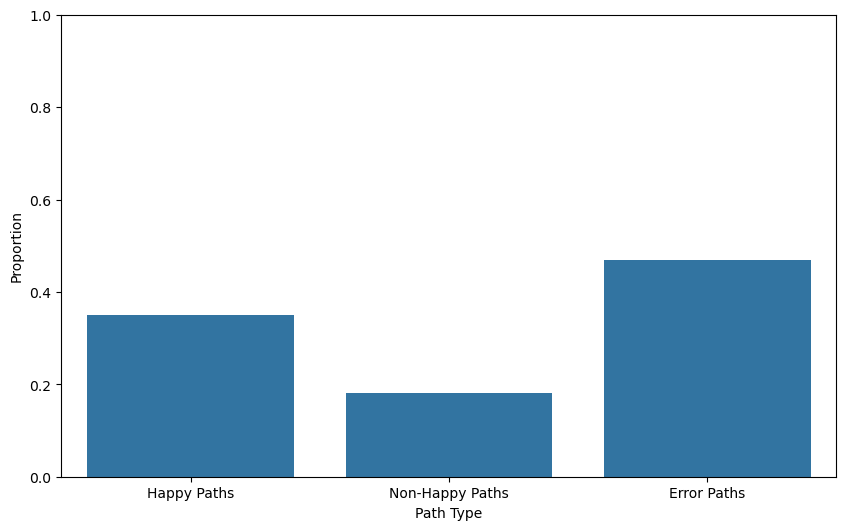

/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_68946/3939993366.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'Happy Paths': happy_paths.groupby('variation')['visit_id'].nunique(),
/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_68946/3939993366.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'Non-Happy Paths': confused_paths.groupby('variation')['visit_id'].nunique(),
/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_68946/3939993366.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obs

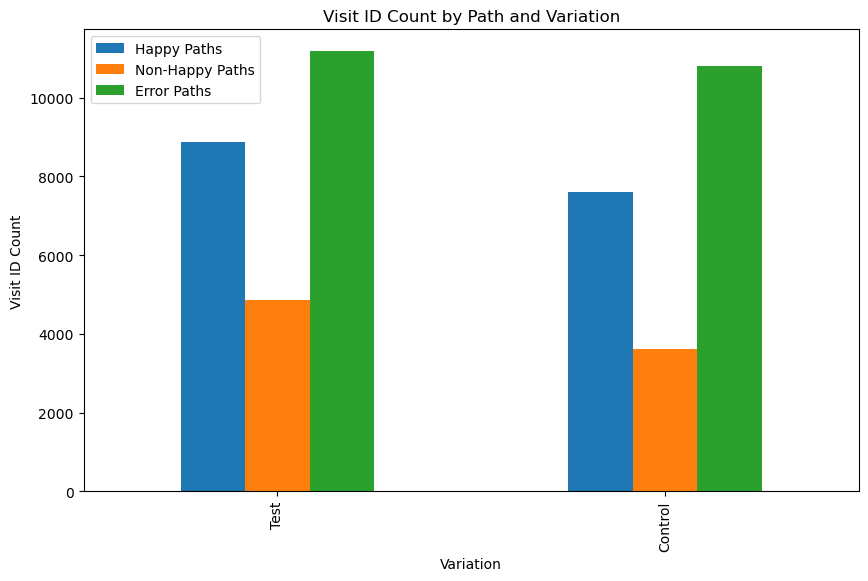

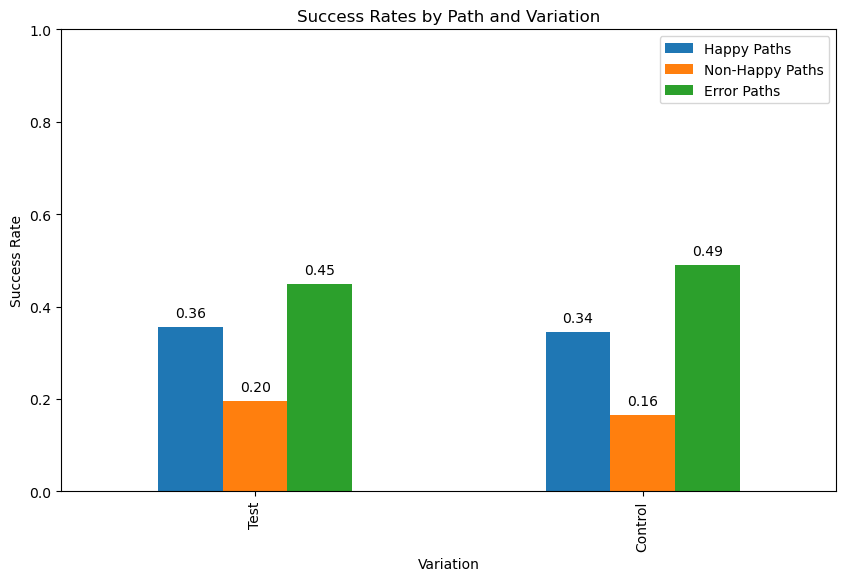

In [57]:
unique_visit_count = visits_variations['visit_id'].nunique()
unique_happy_paths_count = happy_paths['visit_id'].nunique()
unique_non_happy_paths_count = confused_paths['visit_id'].nunique()
unique_error_paths_count = error_paths['visit_id'].nunique()
display((unique_happy_paths_count+unique_non_happy_paths_count+unique_error_paths_count) == unique_visit_count)

proportions = {
    'Happy Paths': unique_happy_paths_count / unique_visit_count,
    'Non-Happy Paths': unique_non_happy_paths_count / unique_visit_count,
    'Error Paths': unique_error_paths_count / unique_visit_count
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(proportions.keys()), y=list(proportions.values()))
plt.xlabel('Path Type')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.show()


path_counts_by_variation = {
    'Happy Paths': happy_paths.groupby('variation')['visit_id'].nunique(),
    'Non-Happy Paths': confused_paths.groupby('variation')['visit_id'].nunique(),
    'Error Paths': error_paths.groupby('variation')['visit_id'].nunique()
}

path_counts_df = pd.DataFrame(path_counts_by_variation)
path_counts_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Variation')
plt.ylabel('Visit ID Count')
plt.title('Visit ID Count by Path and Variation')
plt.show()

success_rates_by_path = {
    'Happy Paths': number_of_successes / number_of_visits,
    'Non-Happy Paths': number_of_visits_non_happy / number_of_visits,
    'Error Paths': number_of_visits_error_path / number_of_visits
}

success_rates_df = pd.DataFrame(success_rates_by_path)
ax = success_rates_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Variation')
plt.ylabel('Success Rate')
plt.title('Success Rates by Path and Variation')
plt.ylim(0, 1)

# Label the bars with the values
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


## COMPLETE FRAME

### Select unique ids

In [58]:
unique_clients_visits = visits_variations.drop_duplicates(subset='client_id')
display(unique_clients_visits)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
106827,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,Test,56,59,U,2,63130.44,6,9,0.0,52.0
236490,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,23,M,2,26436.73,6,9,0.0,242.0
243695,2478628,754122351_18568832435,100022086_87870757897_149620,start,2017-05-23 20:44:01,Test,198,47,F,2,32456.28,2,5,0.0,180.0
235338,105007,676020267_36602664238,100030127_47967100085_936361,start,2017-03-22 11:07:49,Control,118,35,F,2,34897.47,3,6,0.0,0.0
27085,5623007,700426174_33289797318,100037962_47432393712_705583,start,2017-04-14 16:41:51,Control,202,78,M,2,146827.14,5,8,0.0,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128484,9512888,735113752_39198257069,999951892_54774917180_163890,start,2017-04-07 11:21:01,Control,166,39,M,2,45730.25,2,5,0.0,0.0
181050,9498187,599653496_46358190244,999954858_74676709104_879685,start,2017-04-05 11:13:34,Test,60,21,U,2,31295.49,6,9,0.0,127.0
73134,8971313,520929316_99288864740,999958344_67534252886_39917,start,2017-04-15 00:34:32,Test,95,25,U,2,46555.07,6,9,0.0,147.0
8441,2979920,830229399_73416253406,999971096_28827267783_236076,start,2017-04-13 10:31:49,Test,138,28,F,2,83799.17,1,4,0.0,139.0


### Select useful columns

In [59]:
unique_clients_visits = unique_clients_visits[['client_id', 'variation', 'client_since_month', 'client_age', 'gender', 'number_of_accounts', 'balance', 'calls_6_months', 'logons_6_month',	'total_time_taken']]

### Add path column

In [60]:
# Add 'path' column to visits_variations
visits_variations['path'] = 'error'  # Default to 'error'

# Update 'path' column for happy paths
visits_variations.loc[visits_variations['visit_id'].isin(happy_paths['visit_id']), 'path'] = 'happy'

# Update 'path' column for confused paths
visits_variations.loc[visits_variations['visit_id'].isin(confused_paths['visit_id']), 'path'] = 'confused'


### Add helper columns

In [82]:
# Add a column to separate ages into quantile-based groups with similar sizes
visits_variations['age_group'] = pd.qcut(visits_variations['client_age'], q=3, labels=['Younger', 'Middle aged', 'Older'])
display(visits_variations.groupby('age_group', observed=False)['client_age'].describe())

# Add a column to separate balance into quantile-based groups with similar sizes
visits_variations['balance_group'] = pd.qcut(visits_variations['balance'], q=3, labels=['Low Balance', 'Medium Balance', 'High Balance'])
display(visits_variations.groupby('balance_group', observed=False)['balance'].describe())

# Add a column 'is_active' if the client called more than thrice or logged on more than six times
visits_variations['is_active'] = (visits_variations['calls_6_months'] > 6) | (visits_variations['logons_6_month'] >= 6)
display(visits_variations['is_active'].value_counts())

,count,mean,std,min,25%,50%,75%,max
age_group,,,,,,,,
Younger,74037.0,28.938369,4.918568,17.0,25.0,29.0,33.0,37.0
Middle aged,72998.0,47.049851,5.204886,38.0,43.0,47.0,52.0,55.0
Older,70509.0,64.207179,6.473286,56.0,59.0,63.0,68.0,96.0


,count,mean,std,min,25%,50%,75%,max
balance_group,,,,,,,,
Low Balance,72518.0,34331.589597,6228.269995,23789.44,29214.8275,33750.96,39449.15,46188.15
Medium Balance,72511.0,67354.278353,15177.512137,46188.19,54355.3000,64517.16,78709.43,101385.36
High Balance,72515.0,339513.051186,475053.199742,101396.34,136532.4500,201268.81,357514.93,16320040.15


is_active
True     120451
False     97093
Name: count, dtype: int64

## Analysis

In [62]:
# PROPORTION Z TEST ----Happy Paths---- Proportion of successes is greater in Test group than in Control group
# H0: Proportion of complete steps in TEST group <= Proportion of complete steps in CONTROL group
# H1: Pt > Pc
alpha = 0.05

successes = [number_of_successes['Test'], number_of_successes['Control']]
just_visits = [number_of_visits['Test'], number_of_visits['Control']]

happy_results = proportions_ztest(successes, just_visits, alternative = "larger")
display(round(happy_results[0],5),round(happy_results[1],5))


2.54779

0.00542

In [63]:
# PROPORTION Z TEST ----Non Happy Paths----
# H0: Proportion of complete steps in TEST group <= Proportion of complete steps in CONTROL group
# H1: Pt > Pc
alpha = 0.05

successes = [number_of_visits_non_happy['Test'], number_of_visits_non_happy['Control']]
just_visits = [number_of_visits['Test'], number_of_visits['Control']]

confused_results = proportions_ztest(successes, just_visits, alternative = "larger")
display(round(confused_results[0],5),round(confused_results[1],5))


8.70358

0.0

In [64]:
# PROPORTION Z TEST ----Error Paths---- 
# H0: Proportion of visits in TEST group >= Proportion of visits in CONTROL group
# H1: Pt < Pc
alpha = 0.05

successes = [number_of_visits_error_path['Test'], number_of_visits_error_path['Control']]
just_visits = [number_of_visits['Test'], number_of_visits['Control']]

error_results = proportions_ztest(successes, just_visits, alternative = "smaller")
display(round(error_results[0],5),round(error_results[1],5))


-9.15105

0.0

### T-Test for total time

In [65]:
# TWO SAMPLE T TEST ---- Average total_time of success is smaller in Test group than in Control group
import scipy.stats as st
# H0: average time it took to complete steps in test group is greater or equal to one in control group 
#       (Mean_time_test>=Mean_time_control)
# H1: average time it took to complete steps is less in test group than in control group 
#       (Mean_time_test<Mean_time_control)
alpha=0.05
df_test = happy_paths[happy_paths['variation']=='Test']['total_time_taken']
df_control = happy_paths[happy_paths['variation']=='Control']['total_time_taken']
st.ttest_ind(df_test,df_control, equal_var=False, alternative = 'less')

TtestResult(statistic=-38.484288981477185, pvalue=0.0, df=76787.18286811815)

In [66]:
average_time_per_variation = happy_paths.groupby('variation').agg({'total_time_taken': 'mean'})
average_time_per_variation

/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_68946/4127129962.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_time_per_variation = happy_paths.groupby('variation').agg({'total_time_taken': 'mean'})


,total_time_taken
variation,
Test,225.051765
Control,266.943113


In [67]:
# average total time without outliers
avg_total_time = happy_paths['total_time_taken'].mean()
display(avg_total_time)

244.377619828686

In [68]:
# TWO SAMPLE T TEST ---- Average total_time of success is smaller in Test group than in Control group
import scipy.stats as st
# H0: average time it took to complete steps in test group is greater or equal to one in control group 
#       (Mean_time_test>=Mean_time_control)
# H1: average time it took to complete steps is less in test group than in control group 
#       (Mean_time_test<Mean_time_control)
alpha=0.05
df_test = confused_paths[confused_paths['variation']=='Test']['total_time_taken']
df_control = confused_paths[confused_paths['variation']=='Control']['total_time_taken']
st.ttest_ind(df_test,df_control, equal_var=False, alternative = 'less')

TtestResult(statistic=7.278714011822991, pvalue=0.9999999999998294, df=58312.989105716006)

In [69]:
average_time_per_variation = confused_paths.groupby('variation').agg({'total_time_taken': 'mean'})
average_time_per_variation

/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_68946/2527091129.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_time_per_variation = confused_paths.groupby('variation').agg({'total_time_taken': 'mean'})


,total_time_taken
variation,
Test,408.496769
Control,396.880405


In [70]:
# average total time without outliers
avg_total_time = confused_paths['total_time_taken'].mean()
display(avg_total_time)

403.5402498319341

In [71]:
#TODO: consider binning / pd.cut / qcut for numerical data
#TODO: correlation matrix
#TODO: tukeys_test_outliers

In [72]:
# STORY:

# 1. The data had the journeys of 108216 clients in 130607 visits.
    # We selected 

## Visualizations

## Conclusions